In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from z3 import *
import time

### load from file

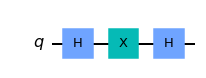

In [2]:
circ0 = QuantumCircuit().from_qasm_file('test.qasm')
circ0.draw('mpl')

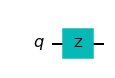

In [3]:
circ1 = QuantumCircuit().from_qasm_file('test1.qasm')
circ1.draw('mpl')

### Some basic functions (maybe useless)

In [4]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def reshape(U):
    if U.shape==(2,2):
        return U
    
    if U.shape[0]==U.shape[1]:
        split_U=np.split(U,2,1)
    else:
        split_U=np.split(U,2,0)
    split_U[0]=reshape(split_U[0])
    split_U[1]=reshape(split_U[1]) 
    return np.array([split_U])[0]            
            
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

### Class of Term

In [5]:
class Term:
    def __init__(self, attr=0.+0.j, ref=None):
        self.attr = attr
        self.ref = ref
    def tensor(self, t1=None):
        attr1 = self.attr * t1.attr
        ref1 = And(self.ref, t1.ref)
        return Term(attr1, ref1)
    def exist(self, ex_list=[]):
        pass
    def sequential(self, t1=None, ex_list=[]): # ex_list: vars
        attr1 = self.attr * t1.attr
        num_ex = len(ex_list)
        ref_0 = And(self.ref, t1.ref)
        res_terms = []
        r = 2 ** num_ex
        for i in range(r):
            ex_var_vals = bin(i)[2:]
            if len(ex_var_vals) < num_ex:
                ex_var_vals = '0' * (num_ex - len(ex_var_vals)) + ex_var_vals
            ref_i = ref_0
            for j in range(num_ex):
                if ex_var_vals[j] == '1':
                    ref_i = And(ref_i, ex_list[j]) # !!!
                else:
                    ref_i = And(ref_i, Not(ex_list[j]))
            res_terms.append(Term(attr1, ref_i))
        return res_terms
    def equalattr(self, t1=None):
        return self.attr == t1.attr
#     def equalref(self, t1=None):
#         # check ref equivalence
#         return False
#     def contra(self, t1=None):
#         # check conrtradictoriness
#         return False
#     def shrink(self):
#         # simplify ref
#         pass
#     def reduce(self, t1=None):
#         if self.equalref(t1):
#             return Term(self.attr+t1.attr, self.ref)
#         elif self.contra(t1) and self.equalattr(t1):
#             pass
#         pass

In [6]:
def genRef(r, c, input_qubits, var_list, tt_input_num, q, curr_output):
#     print(tt_input_num)
#     if curr_output == 0:
#         bias_in = 0
#         bias_out = 1
#     elif curr_output == 1:
#         bias_in = 1
#         bias_out = 2
#     else:
#         bias_in = 2
#         bias_out = 1
    bias_in = curr_output
    bias_out = 2 if curr_output == 1 else 1
    input_vars = bin(r)[2:]
    if len(input_vars) < input_qubits:
        input_vars = '0'*(input_qubits-len(input_vars)) + input_vars
    output_vars = bin(c)[2:]
    if len(output_vars) < input_qubits:
        output_vars = '0'*(input_qubits-len(output_vars)) + output_vars
    reslist = []
    for i,e in enumerate(input_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_in*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_in*tt_input_num]))
    for i,e in enumerate(output_vars):
        if e == '1':
            reslist.append(var_list[q[i]+bias_out*tt_input_num])
        else:
            reslist.append(Not(var_list[q[i]+bias_out*tt_input_num]))
    return And(tuple(reslist))

In [7]:
from functools import cmp_to_key

class CVBE:
    def __init__(self, termlist=[]): # Assume that terms are already regularized
        if termlist != []:
            self.termdict = self.gen_termdict(termlist)
        else:
            self.termdict = {}
    def gen_termdict(self, termlist):
        termdict = {}
        for term in termlist:
            if term.attr not in termdict:
                termdict[term.attr] = [term]
            else:
                termdict[term.attr].append(term)
        for attr in termdict:
            if len(termdict[attr]) > 1:
                term_rd = Term(attr, Or(tuple([t.ref for t in termdict[attr]])))
                termdict[attr] = term_rd
            else:
                termdict[attr] = termdict[attr][0]
        return termdict
    def reduce(self):
        del_list = []
        for key in self.termdict:
            solver = Solver()
            ref = self.termdict[key].ref
            solver.add(ref)
            if solver.check() == z3.unsat:
                del_list.append(key)
        for key in del_list:
            del self.termdict[key]
    def regularize(self, termlist=[]):
        if termlist == []:
            termlist = self.termdict.values() # len > 0
        ref_list = [term.ref for term in termlist]
        attr_list = [term.attr for term in termlist]
        term_num = len(termlist)
        ref_new_list, attr_new_list = [ref_list[0]], [attr_list[0]]
        for i in range(1, term_num): # curr_ref: ref_list[i]
            ref_new = ref_list[i]
            curr_term_num = len(ref_new_list)
            for j in range(curr_term_num):
                ref_new = And(ref_new, Not(ref_new_list[j]))
                if attr_list[i] + attr_new_list[j] != 0:
                    ref_update0 = And(ref_list[i], ref_new_list[j])
                    ref_new_list.append(ref_update0)
                    attr_new_list.append(attr_list[i]+attr_new_list[j])
#                     print('Here come in')
                ref_update1 = And(Not(ref_list[i]), ref_new_list[j])
                ref_new_list.append(ref_update1)
                attr_new_list.append(attr_new_list[j])
            ref_new_list.append(ref_new)
            attr_new_list.append(attr_list[i])
            ref_new_list = ref_new_list[curr_term_num:]
            attr_new_list = attr_new_list[curr_term_num:]
        term_new_list = [Term(attr_new_list[i], ref_new_list[i]) for i in range(len(ref_new_list))]
        termdict_new = dict(zip(attr_new_list, term_new_list))
        self.termdict = termdict_new
    def equals(self, c1, threshold=0.001):
        if len(self.termdict) != len(c1.termdict):
            return False
        length = len(self.termdict)
        termlist0 = sorted(self.termdict.items(), key=cmp_to_key(lambda x,y: x[0].real > y[0].real or x[0].imag > y[0].imag))
        termlist1 = sorted(c1.termdict.items(), key=cmp_to_key(lambda x,y: x[0].real > y[0].real or x[0].imag > y[0].imag))
        print([term[0] for term in termlist0])
        print([term[0] for term in termlist1])
        res = True
        for i in range(len(termlist0)):
            attr_diff = termlist0[i][0]-termlist1[i][0]
            if abs(attr_diff.real) + abs(attr_diff.imag) >= threshold:
#                 print('attr_diff: ', attr_diff)
                res = False
            solver = Solver()
            solver.add(termlist0[i][1]!=termlist1[i][1])
            if solver.check() == z3.sat:
#                 print('sat')
                res = False
            if res == False:
                return res
        return res
    def tensor(self, c1):
        termlist1 = []
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1.append(term1.tensor(term2))
        return CVBE(termlist1)
    def sequential(self, c1, ex_list=[]):
        termlist1 = []
#         print(len(self.termdict), len(c1.termdict))
        for term1 in self.termdict.values():
            for term2 in c1.termdict.values():
                termlist1 += (term1.sequential(term2, ex_list))
        print(len(termlist1))
        c0 = CVBE();
        c0.regularize(termlist1)
        c0.reduce()
        print(len(c0.termdict))
        return c0
#     @classmathod
#     def identity(cls):
#         pass

In [8]:
def gen_cvbe(circ):
    qubits_num = get_real_qubit_num(circ)
    vars_num = qubits_num
    var_list = []
    for i in range(3*vars_num):
        var_list.append(Bool(str(i)))
    curr_output = 0
    # number of gates
    gates = circ.data
    circ_cvbe = None
    for k in range(len(gates)):
        g=gates[k] # information of the kth gate
        nam=g[0].name
        q = [q.index for q in g[1]] # involved qubits of the gate
    #     print(g, nam, q)
        U = Operator(g[0]).data
        termlist = []
    #     print(U.shape)
        for r in range(U.shape[0]):
            for c in range(U.shape[1]):
                if U[r][c] != 0:
                    ref = genRef(r,c,len(q), var_list, vars_num, q, curr_output)
                    termlist.append(Term(U[r][c], ref))
        internal_vars = var_list[curr_output*vars_num:(curr_output+1)*vars_num]
        curr_output = 2 if curr_output == 1 else 1
        cvbe = CVBE(termlist)
        if circ_cvbe == None:
            circ_cvbe = cvbe
        else:
            circ_cvbe = circ_cvbe.sequential(cvbe, internal_vars)
    #         circ_cvbe = circ_cvbe.tensor(cvbe)
    return circ_cvbe

In [9]:
cvbe0 = gen_cvbe(circ0)
# cvbe0.regularize()
# cvbe1 = gen_cvbe(circ1)
# cvbe1.regularize()

<ipython-input-4-77c3d43aa436>:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q=max(q,max([qbit.index for qbit in gates[k][1]]))
<ipython-input-8-66331a2fb79c>:14: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q = [q.index for q in g[1]] # involved qubits of the gate


4
2
8
0


In [10]:
# cvbe0.equals(cvbe1)

In [11]:
cvbe0.termdict

{}

In [21]:
a, b = Bools('a b')
x = Or(a, Exists(a,And(a,b)))
y = Or(a, b)
solver = Solver()
solver.add(x!=y)
solver.check()

unsat

In [14]:
y

Exists(a, And(a, b))